### 목표
- 버섯의 특징을 활용해서 독성/식용 버섯을 분류하는 실습을 해보자
- Decition Tree 분류 모델을 학습하고 시각화 및 과대적합 제어를 해보자
- 모델 자체적으로 중요도가 높은 특성이 무엇인지 확인해보자

#### Lib, 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('./data/mushroom.csv')
data.head(5)
data.info()
# 답데이터 -> poisonous, 문제데이터 -> poisonous를 제외한 나머지

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   poisonous                 8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

#### 데이터 전처리 및 탐색
- 문제(특성) 과 답(라벨) 분리

In [4]:
data.columns

Index(['poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [5]:
# 컬럼 인덱싱
X = data.iloc[:, 1:]
y = data['poisonous']
print(X.shape, y.shape)

(8124, 22) (8124,)


In [6]:
# 문제 데이터의 기술 통계량 확인
# 최소, 최대, 중앙, 최빈(가장 많이 관측되는 수), 평균 값 ...
# 문자 형태인 범주형 데이터 -> 최빈값만 구할 수 있다. 어떤 알파벳이 가장 많이 등장했는가!
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,...,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [7]:
# 독성, 식용은 각각 몇개씩 들어있을까?
y.value_counts()

poisonous
e    4208
p    3916
Name: count, dtype: int64

#### 인코딩 : 범주(문자) -> 수치
- 레이블 인코딩
- 원핫 인코딩

In [8]:
# pd.get_dummies(대상) : 원 핫 인코딩
X_oh = pd.get_dummies(X)
X_oh.shape

(8124, 117)

In [9]:
X_oh.head(1)

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False


In [10]:
# 훈련 세트와 테스트 세트로 분리
# X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=0.1, train_size=0.7, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X_oh, y, train_size=0.7, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=0.3, random_state=5)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5686, 117) (2438, 117) (5686,) (2438,)


#### 모델링
- tree 모델 생성 and 학습

In [11]:
tree_model = DT()
# 기본 값으로 노드의 깊이를 최대로 한다
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

- 모델의 일반화 성능 확인 : 교차검증(cross-validation)
    - 개념 : 일반화 성능 측정 방법 > 모든 데이터에 대해 모델이 얼마나 잘 맞추는지 <br>
            내부적으로 평가, 한 번의 train으로 test하는 것보다 안정적인 방법
    - 방법론 : 훈련 세트를 기준으로 훈련세트와 검증용 세트로 여러겹 나눠서 평가
    - 모델을 정의하고 학습하기 전에 정확도가 어느 정도일지 확인하는 것이 가능하다
    - 장점 : 과대적합, 과소적합 방지, test하기 전에 정확도를 미리 알 수 있다

In [12]:
# cross_val_score()
from sklearn.model_selection import cross_validate as cv

In [13]:
result = cv(tree_model, X_train, y_train, cv=5)
result
# 해당 모델이 버섯 분류에 있어 과대적합을 제어하지 않아도 성능이 좋은 상태
# 과대적합을 제어할 필요가 없다

{'fit_time': array([0.02299738, 0.01599932, 0.01699853, 0.01599455, 0.01600885]),
 'score_time': array([0.0049994 , 0.00300169, 0.00402689, 0.00299954, 0.00399613]),
 'test_score': array([1.        , 0.99912049, 1.        , 1.        , 1.        ])}

In [14]:
# X_test 성능확인
# accuracy_score(실제값, 예측값)
# 간혹 모델 자체적으로 정확도 평가 함수를 가지고 있는 경우가 있다
test_acc = tree_model.score(X_test, y_test)
test_acc

1.0

### 모델이 선택한 특성 중요도 확인
- 특성 선택
- tree 계열의 모델은 특성 중요도를 출력하는 키워드가 존재

In [15]:
X_oh.columns

Index(['cap-shape_b', 'cap-shape_c', 'cap-shape_f', 'cap-shape_k',
       'cap-shape_s', 'cap-shape_x', 'cap-surface_f', 'cap-surface_g',
       'cap-surface_s', 'cap-surface_y',
       ...
       'population_s', 'population_v', 'population_y', 'habitat_d',
       'habitat_g', 'habitat_l', 'habitat_m', 'habitat_p', 'habitat_u',
       'habitat_w'],
      dtype='object', length=117)

In [16]:
fi = tree_model.feature_importances_
fi

array([0.00000000e+00, 1.40651446e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.04140350e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.97540490e-02, 0.00000000e+00,
       0.00000000e+00, 2.29748984e-02, 0.00000000e+00, 6.08941189e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.88889569e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.84017476e-01, 0.00000000e+00, 8.36812810e-02,
      

In [17]:
fi_df = pd.DataFrame(fi, index=X_oh.columns, columns=['import'])
fi_df

# 특성 중요도를 내림차순 정렬해보자 -> Top 5
fi_df['import'].sort_values(ascending=False).head()

odor_n                 0.608941
stalk-root_c           0.184017
stalk-root_r           0.083681
spore-print-color_r    0.034899
odor_a                 0.029754
Name: import, dtype: float64

### tree 모델 시각화
- 시각화 패키지 설치

In [18]:
# ! pip install graphviz

In [19]:
from sklearn.tree import export_graphviz

In [26]:
export_graphviz(tree_model, out_file='./data/tree.dot', class_names=['독', '식'],
                impurity=False, # 지니 불순도와 유사한 개념
                filled= True, feature_names=X_oh.columns)

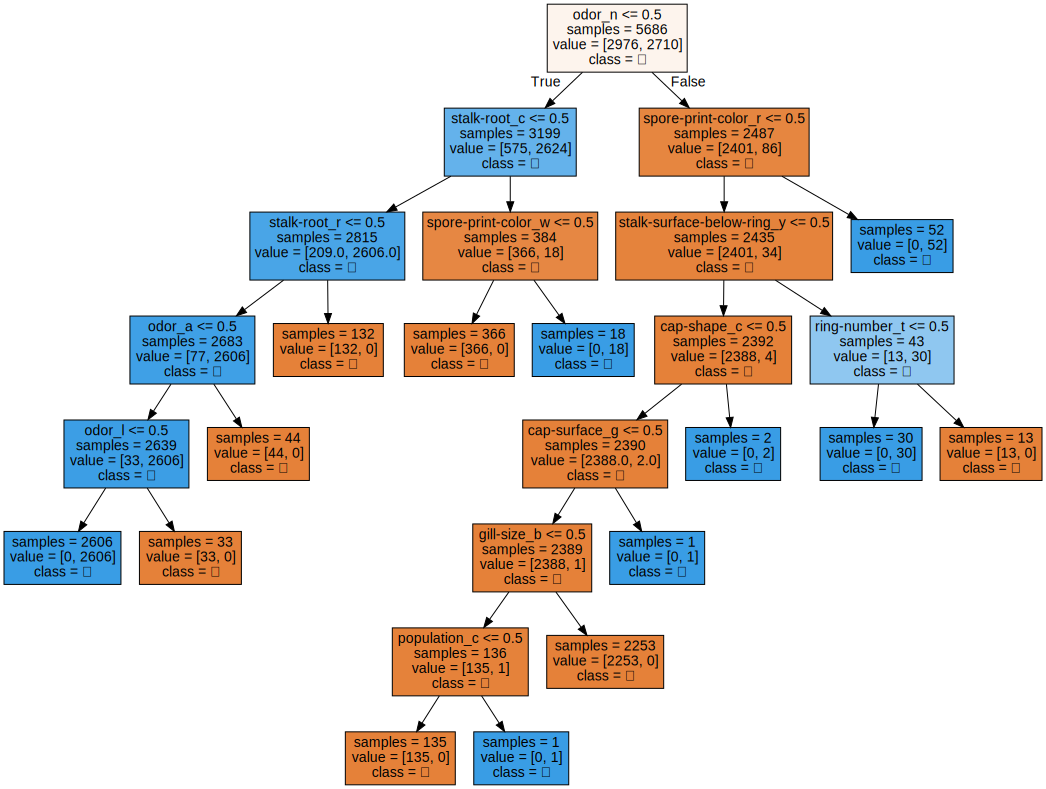

In [27]:
import graphviz
with open('./data/tree.dot', encoding='UTF8') as f:
    dot_graph = f.read()
dot_graph
display(graphviz.Source(dot_graph))

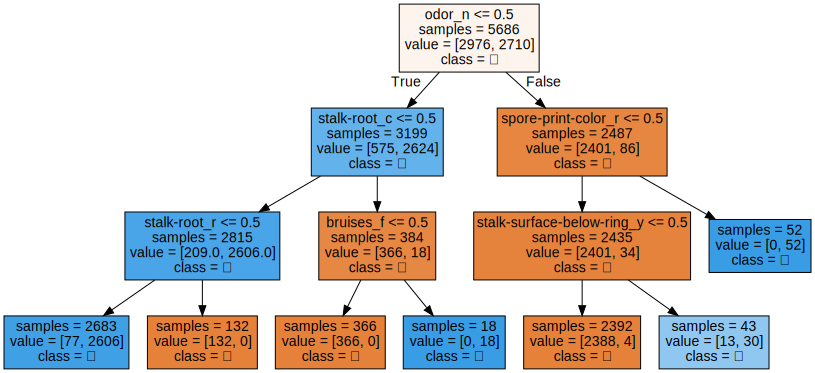

In [ ]:
tree_model = DT(max_depth=3)
tree_model.fit(X_train, y_train)
export_graphviz(tree_model, out_file='./data/tree2.dot', class_names=['독', '식'],
                impurity=False,
                filled= True, feature_names=X_oh.columns)
with open('./data/tree2.dot', encoding='UTF8') as f:
    dot_graph = f.read()
dot_graph
display(graphviz.Source(dot_graph))